In [1]:
import pretty_midi
import numpy as np
import glob
import mido
import os

notes_array = np.load('notes_array.npy')
velocities_array = np.load('velocities_array.npy')

#normalize
#帶來以下好處:
#1. 處理不同尺度的數據
#2. 加快模型收斂速度

#change shape
notes_normalized = notes_array.reshape(-1, 1) / int(notes_array.max())
velocities_normalized = velocities_array.reshape(-1, 1) / float(velocities_array.max())

# combine notes and velocities
combined_data = np.concatenate((notes_normalized, velocities_normalized), axis=1)
combined_data.shape

(2599480, 2)

In [2]:
sequence_length = 5
inputs = []
targets = []

for i in range(len(combined_data) - sequence_length):
    inputs.append(combined_data[i:i+sequence_length])
    targets.append(combined_data[i+sequence_length])


#split data
split_index = int(0.8 * len(inputs)) 

train_inputs = np.array(inputs[:split_index])
train_targets = np.array(targets[:split_index])

test_inputs = np.array(inputs[split_index:])
test_targets = np.array(targets[split_index:])

In [3]:
len(inputs), len(targets)

(2599475, 2599475)

In [4]:
train_inputs.shape, train_targets.shape, test_inputs.shape, test_targets.shape

((2079580, 5, 2), (2079580, 2), (519895, 5, 2), (519895, 2))

In [5]:
import tensorflow as tf

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(train_inputs.shape[1], train_inputs.shape[2])),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)  
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.RepeatVector(train_inputs.shape[1]),  
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(train_inputs.shape[2]) 
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(10, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

optimizer = tf.keras.optimizers.legacy.Adam()

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(inputs, targets, model, optimizer):
    batch_inputs = tf.cast(inputs, dtype=tf.float32)
    batch_targets = tf.cast(targets, dtype=tf.float32)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, batch_inputs)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


epochs = 20
latent_dim = 2
num_examples_to_generate = 5
losses = []

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)



train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(len(train_inputs)).batch(64)

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for batch_inputs, batch_targets in train_dataset:
        batch_loss = train_step(batch_inputs, batch_targets, model, optimizer)
        epoch_loss += batch_loss
        num_batches += 1
        
    avg_loss = epoch_loss / num_batches
    print('Epoch {} Loss: {:.6f}'.format(epoch + 1, avg_loss))
    losses.append(avg_loss)
generated_samples = model.sample(random_vector_for_generation)

2023-07-03 04:43:47.407398: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 Loss: 6.504933
Epoch 2 Loss: 6.504521
Epoch 3 Loss: 6.504414
Epoch 4 Loss: 6.504389
Epoch 5 Loss: 6.504351
Epoch 6 Loss: 6.504322
Epoch 7 Loss: 6.504290
Epoch 8 Loss: 6.504308
Epoch 9 Loss: 6.504269
Epoch 10 Loss: 6.504272
Epoch 11 Loss: 6.504237
Epoch 12 Loss: 6.504268
Epoch 13 Loss: 6.504246
Epoch 14 Loss: 6.504270
Epoch 15 Loss: 6.504294
Epoch 16 Loss: 6.504268
Epoch 17 Loss: 6.504270
Epoch 18 Loss: 6.504261
Epoch 19 Loss: 6.504278
Epoch 20 Loss: 6.504263


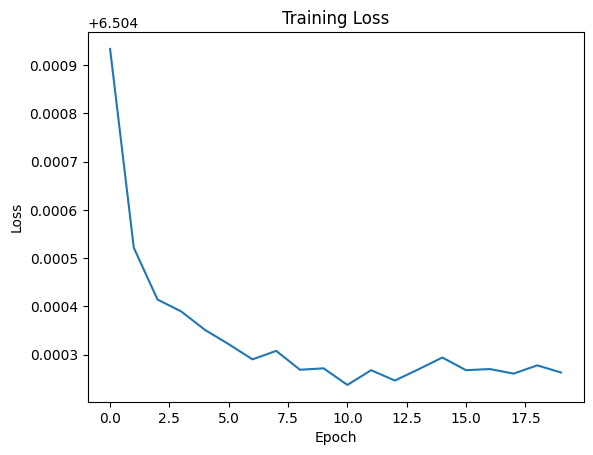

In [6]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
generated_samples_denormalized = generated_samples * np.array([notes_array.max(), velocities_array.max()])

In [8]:
from music21 import stream, note, tempo

for i in range(generated_samples_denormalized.shape[0]):
    generated_sequence = generated_samples_denormalized[i]
    
    music_stream = stream.Stream()
    
    # 将生成的音符序列添加到音乐流中
    for note_data in generated_sequence:
        new_note = note.Note()
        new_note.pitch.midi = int(note_data[0])
        new_note.volume.velocity = int(note_data[1])
        music_stream.append(new_note)

    # 保存为 MIDI 文件
    path = '/Users/rich/Desktop/AI-Music-Main/Generated_Music/'
    music_stream.write('midi', fp=path + 'generated_music_{}.mid'.format(i))
